# Mixed Certain and Uncertain Inputs

Sometimes only some of the input parameters are uncertain. This situation can easily be handled by using the ``Delta`` distribution.

In [1]:
from golem import *

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set(context='talk', style='ticks')

Let's define and plot an objective function.

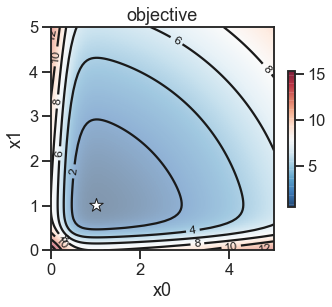

In [20]:
def objective(x0, x1):        
    fx0 = 10 / (1 + 0.3 * np.exp(6 * x0)) + 0.1 * np.abs(2 * x0**2)
    fx1 = 10 / (1 + 0.3 * np.exp(6 * x1)) + 0.1 * np.abs(2 * x1**2)
    return fx0 + fx1

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='RdBu_r'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha)
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    # mark minima
    ax.scatter([X0.flatten()[np.argmin(y)]], [X1.flatten()[np.argmin(y)]], 
            s=200, color='white', linewidth=1, edgecolor='k', marker='*', zorder=20)
        
    ax.set_aspect('equal', 'box')
    return mappable


# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

x0 = np.linspace(0, 5, 100)
x1 = np.linspace(0, 5, 100)
X0, X1 = np.meshgrid(x0, x1)
Y = objective(X0, X1)

_ = plot_contour(ax, X0, X1, Y, [0, 5], [0, 5], cbar=True)
_ = ax.set_xlabel('x0')
_ = ax.set_ylabel('x1')
_ = ax.set_title('objective')

Now we assume that ``x0`` can be exactly controlled and as such does not have any uncertainty, while ``x1`` is noisy and its uncertainty can be described by a Normal distribution with a standard deviation of 1. So we use ``Delta`` for ``x0`` and ``Normal`` for ``x1``.

[INFO] Golem ... 1 tree(s) parsed in 2.70 s ...
[INFO] Golem ... Convolution of 10000 samples performed in 7.35 s ...


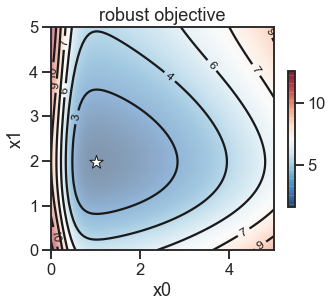

In [21]:
distributions = [Delta(), Normal(std=1)]

# put data into a pandas dataframe
Xy = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten(), 'y': Y.flatten()})
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1:]

# compute the robust objective
golem = Golem(ntrees=1, random_state=42, nproc=1)
golem.fit(X=X, y=y)
y_robust = golem.predict(X=X, distributions=distributions)
Y_robust = np.reshape(y_robust, newshape=np.shape(X0))

# plot robust surface
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
_ = plot_contour(ax, X0, X1, Y_robust, [0, 5], [0, 5], cbar=True)
_ = ax.set_xlabel('x0')
_ = ax.set_ylabel('x1')
_ = ax.set_title('robust objective')